# 2) Dataset Overview

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import re
import ast
import unicodedata
import seaborn as sns
import warnings
from openai import OpenAI
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")


## a) The Textual Database: ECB Press

### A quick overview:

We have access to several features, thanks to our scraping process:

- The URL of the different press articles scraped.
- The publication date of each article.
- The full content of the articles.
- Titles for most articles, except for some PDF files where identifying the title was challenging.
- Topics assigned to each text, helping to identify the main subject of the article.

In [81]:
df_texte = pd.read_parquet("../data/ecb_press.parquet")
df_topic = pd.read_csv("../data/df_alex.csv", index_col=-1)
df_topic["topic"] = df_topic["topic"].apply(ast.literal_eval)

df = pd.concat([
    pd.read_parquet("../data/ecb_press.parquet").merge(
        pd.read_csv("../data/df_alex.csv", index_col=-1)[["url", "topic"]].assign(
            topic=lambda x: x["topic"].apply(ast.literal_eval)
        ),
        on="url", how="left"
    )
], axis=0)

df = df.explode('topic')


### Some Statistical Analysis

/var/folders/7q/v0vj3h051dn717mx7ngrr8yh0000gn/T/ipykernel_49099/1482284812.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_30, x="count", y="topic", palette="coolwarm")


Text(0, 0.5, 'Sujet')

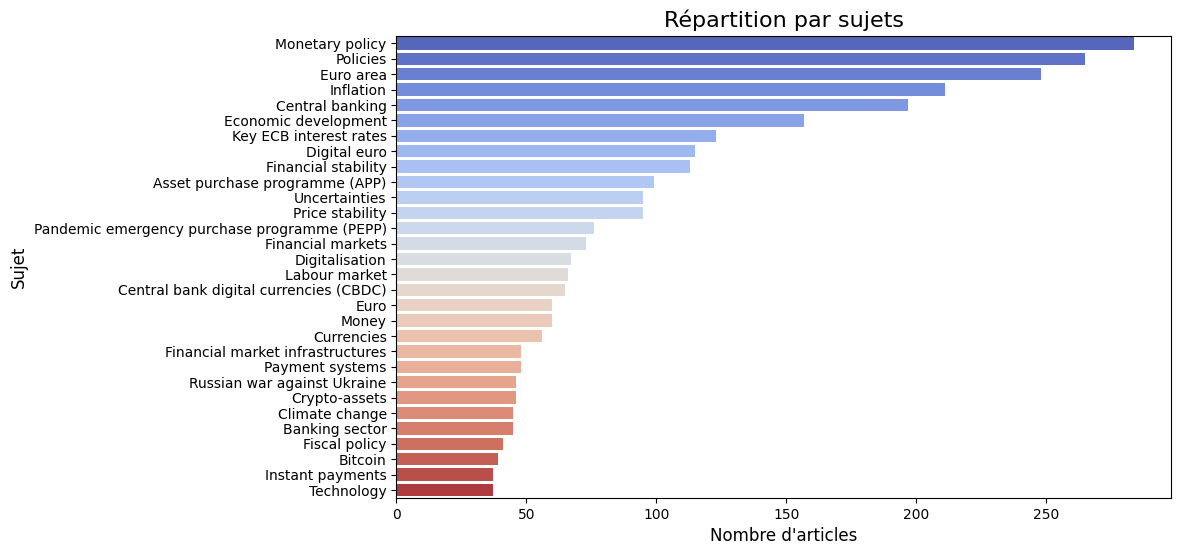

In [73]:
top_30 = df["topic"].value_counts().head(30).reset_index()
top_30.columns = ["topic", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_30, x="count", y="topic", palette="coolwarm")
plt.title("Répartition par sujets", fontsize=16)
plt.xlabel("Nombre d'articles", fontsize=12)
plt.ylabel("Sujet", fontsize=12)


This bar plot highlights the ECB's focus over time. Core topics like "Monetary Policy" dominate every year, reflecting their importance. Peaks in 2020 and 2022 likely correspond to the COVID-19 pandemic and the energy crisis, with increased mentions of "Asset Purchase Programme (APP)" and "Key ECB Interest Rates." The ECB's priorities clearly adapt to significant economic events.

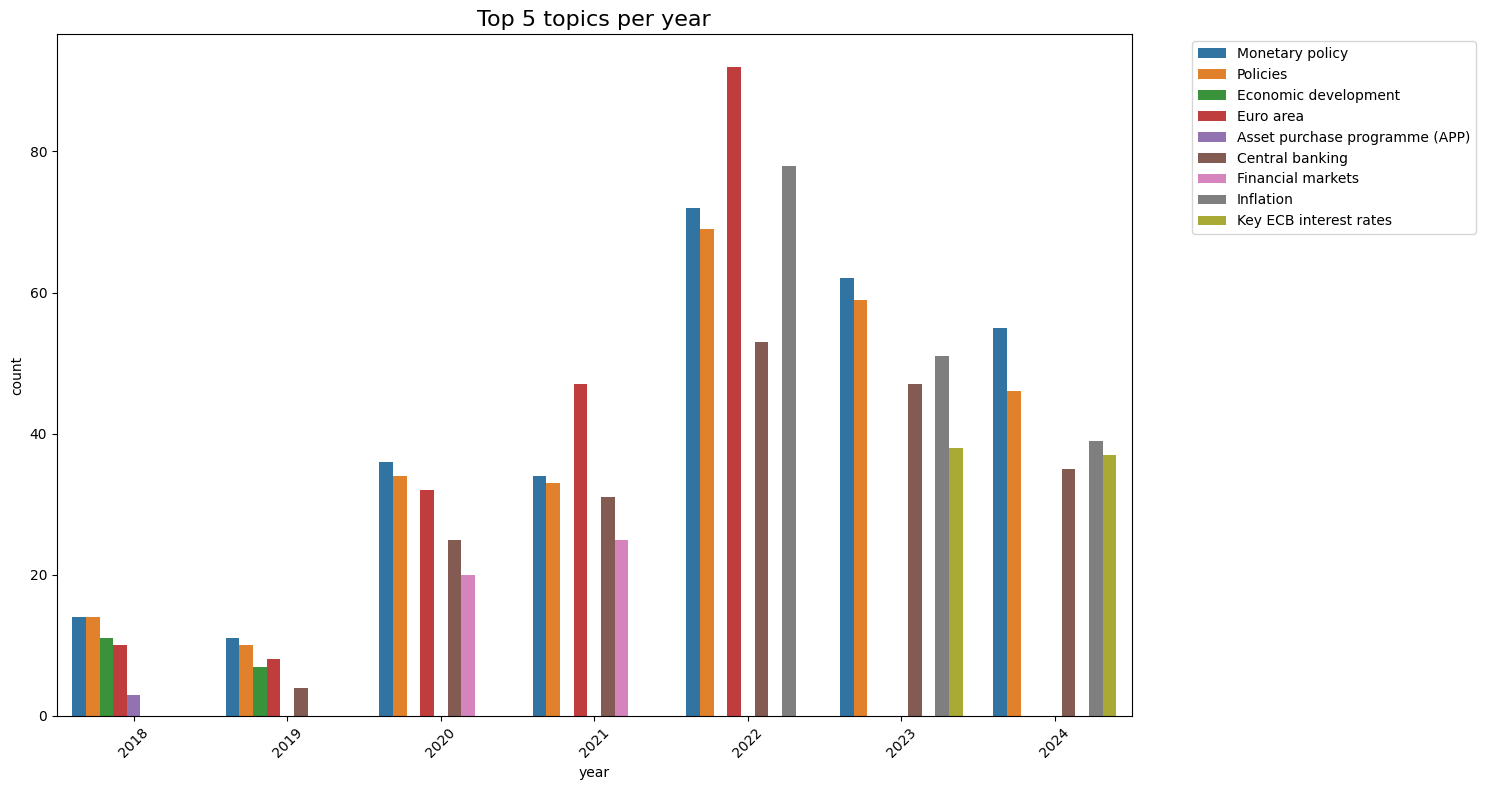

In [79]:
df['year'] = pd.to_datetime(df['date']).dt.year
yearly_top5 = df.groupby(['year', 'topic']).size().reset_index(name='count')
yearly_top5 = yearly_top3.sort_values(['year', 'count'], ascending=[True, False]).groupby('year').head(5)

plt.figure(figsize=(15, 8))
sns.barplot(data=yearly_top5, x='year', y='count', hue='topic', dodge=True, width=0.8)
plt.title('Top 5 topics per year', fontsize=16)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The chart above shows the distribution of topics covered in press articles published by the European Central Bank (ECB). It is evident that most articles focus on monetary policy, general policies, and inflation, reflecting the ECB's core role in macroeconomic regulation.

On the other hand, topics such as financial markets, international relations, and central bank digital currencies (CBDC) are less frequently discussed, despite their strategic importance in the current economic environment.

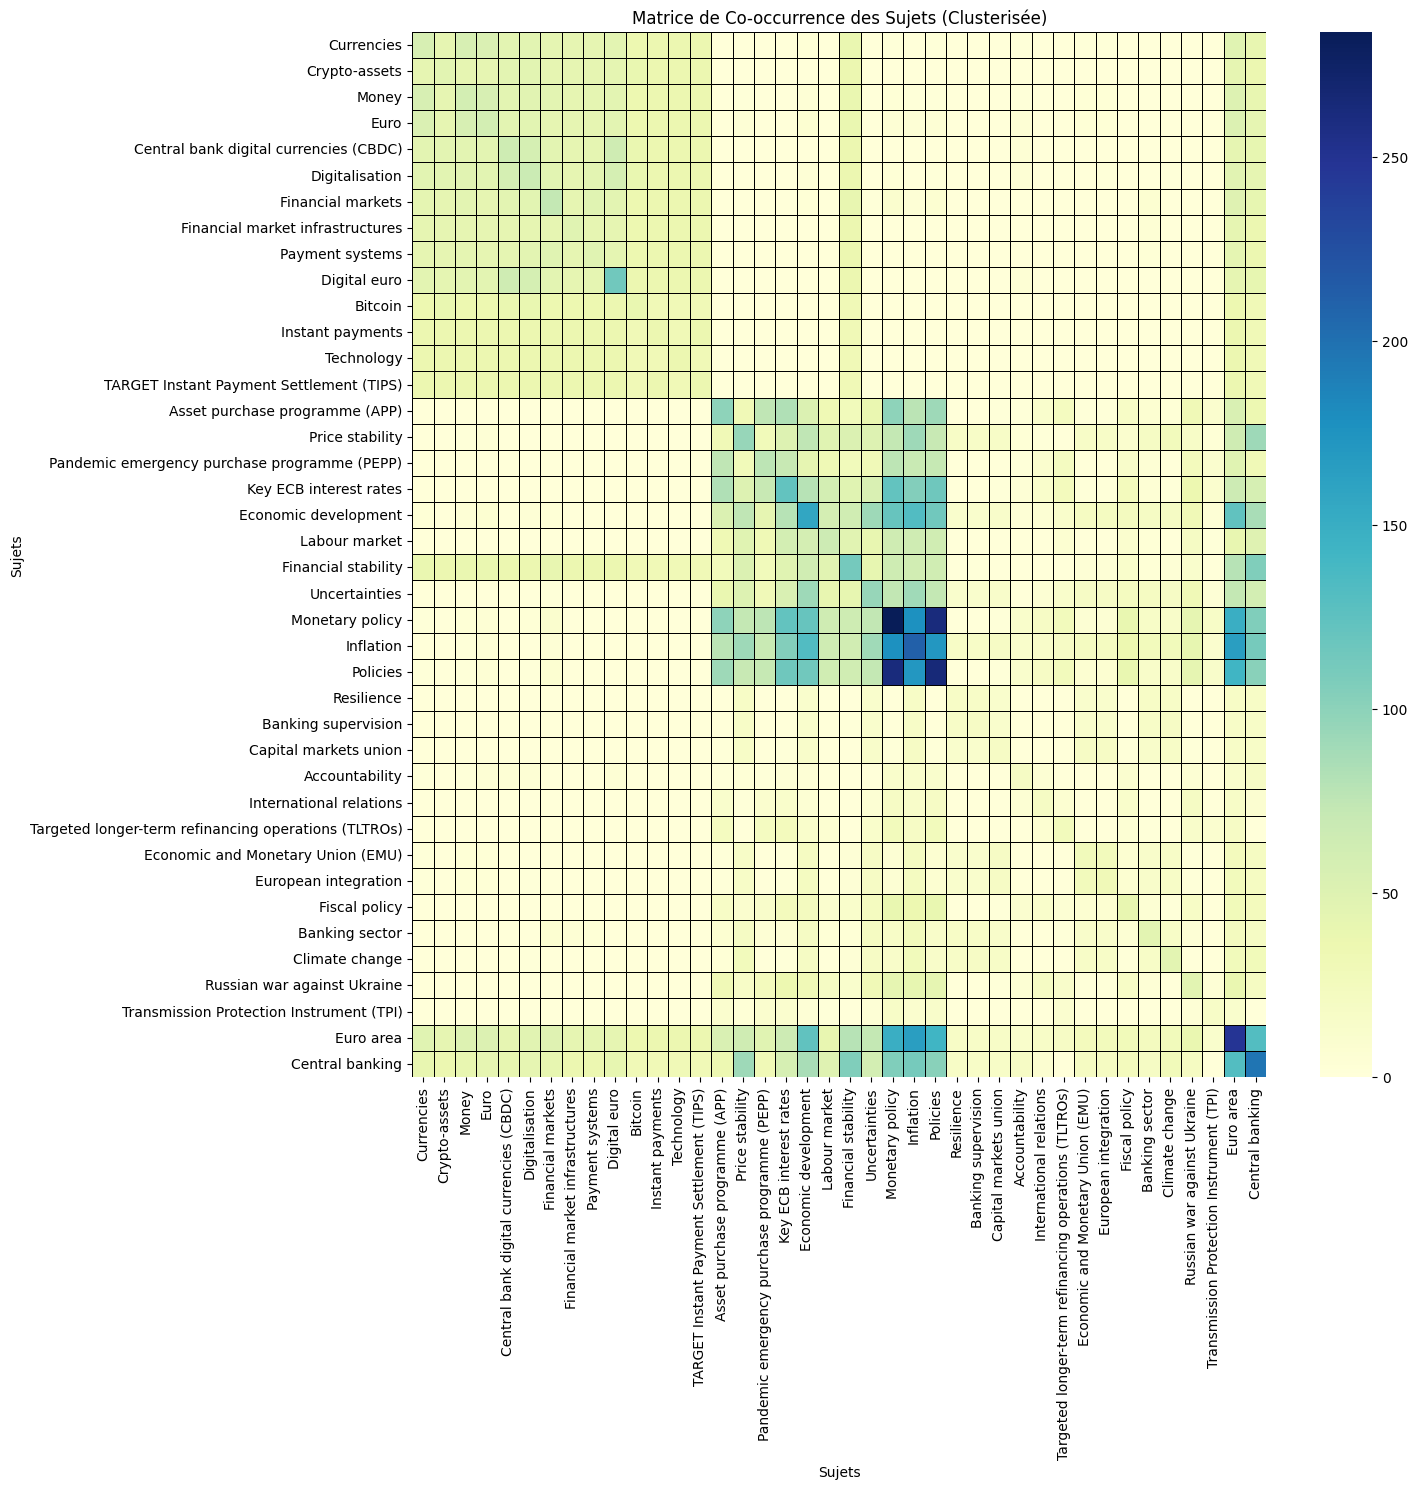

In [90]:
df = df.explode('topic')
top_topics = df['topic'].value_counts().head(40).index
binary_matrix = pd.crosstab(df.index, df['topic'])[top_topics]
co_occurrence_matrix = binary_matrix.T.dot(binary_matrix)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto').fit(co_occurrence_matrix)
sorted_topics = pd.Series(kmeans.labels_, index=co_occurrence_matrix.columns).sort_values().index
co_occurrence_matrix_sorted = co_occurrence_matrix.loc[sorted_topics, sorted_topics]

plt.figure(figsize=(15, 15))
sns.heatmap(
    co_occurrence_matrix_sorted, cmap='YlGnBu', annot=False, fmt='d', 
    linewidths=0.5, linecolor='black'
)
plt.title("Matrice de Co-occurrence des Sujets (Clusterisée)")
plt.xlabel("Sujets")
plt.ylabel("Sujets")
plt.tight_layout()
plt.show()

## b) The Financial Data We will Consider :

### 1. **Indices**
- **EURO STOXX 50**: Represents the 50 largest stocks in the Eurozone, providing a benchmark for large-cap performance in Europe.

Both indices are combined into a single DataFrame for comparative analysis.

### 2. **European Sector Data**
We analyze sector-specific performance using the STOXX Europe 600 ETFs for the following industries:
- **Banks**: `EXH1.DE` (iShares STOXX Europe 600 Banks)
- **Oil & Gas**: `EXH2.DE` (iShares STOXX Europe 600 Oil & Gas)
- **Technology**: `EXH4.DE` (iShares STOXX Europe 600 Technology)
- **Healthcare**: `EXH3.DE` (iShares STOXX Europe 600 Healthcare)
- **Utilities**: `EXH5.DE` (iShares STOXX Europe 600 Utilities)

### 3. **Data Period and Frequency**
- **Time Period**: 1 year of historical data.
- **Frequency**: Daily closing prices.

[*********************100%***********************]  6 of 6 completed


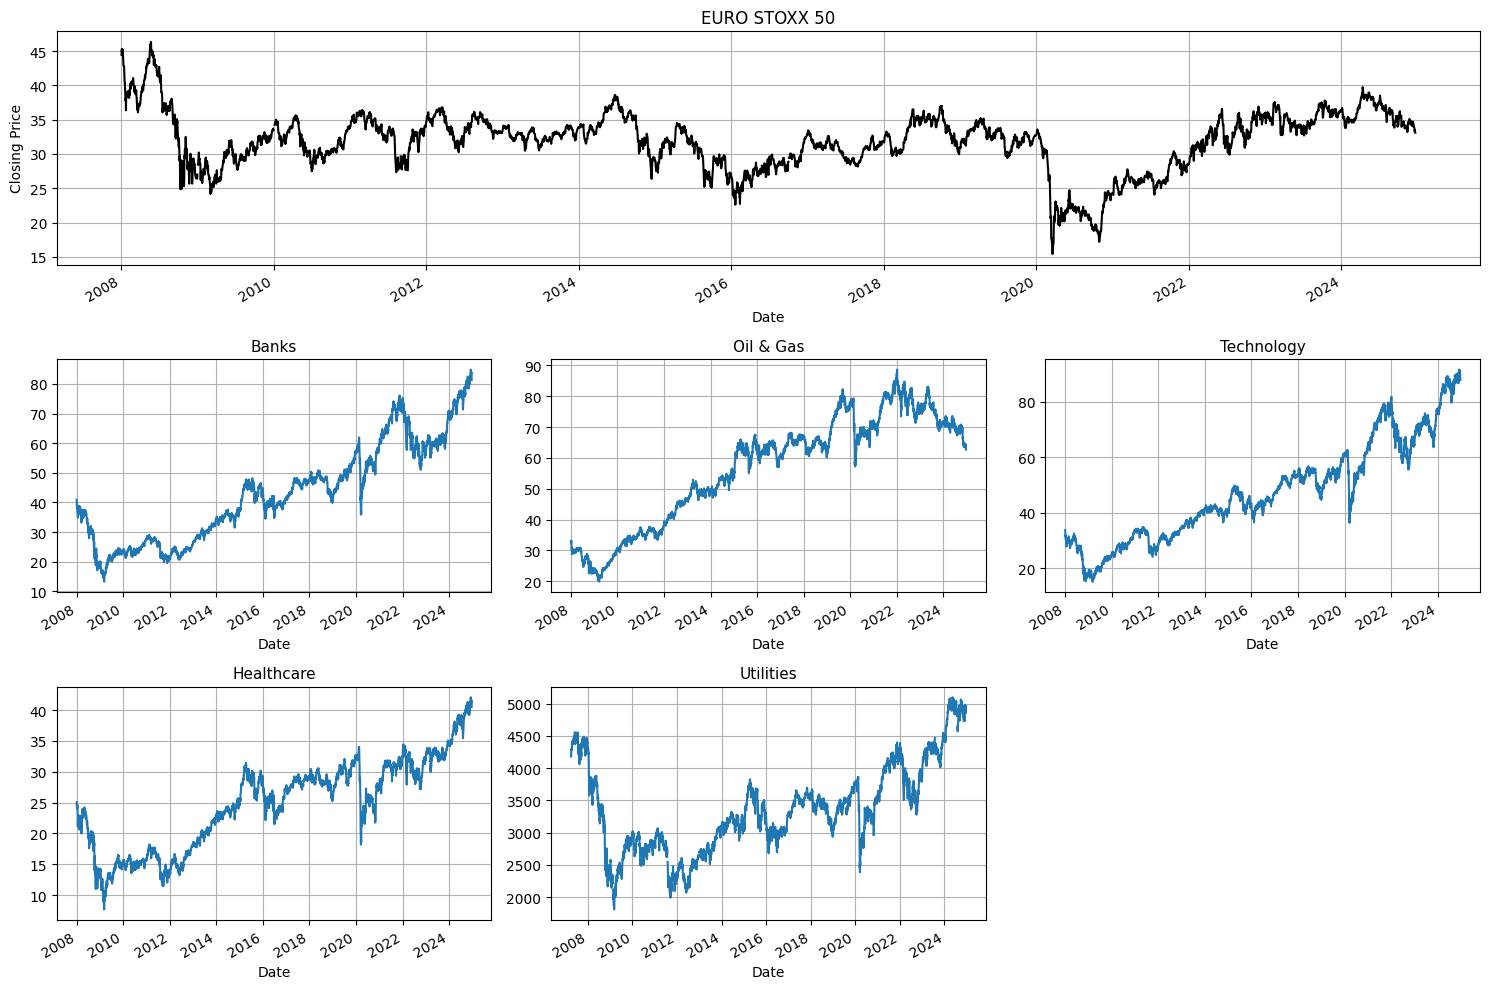

In [100]:
import yfinance as yf
import matplotlib.pyplot as plt

tickers = {
    "EURO STOXX 50": "^STOXX50E",
    "Banks": "EXH1.DE",
    "Oil & Gas": "EXH2.DE",
    "Technology": "EXH4.DE",
    "Healthcare": "EXH3.DE",
    "Utilities": "EXH5.DE"
}


data = yf.download(list(tickers.values()), start="2007-01-01")['Close']
data.columns = tickers.keys()

fig = plt.figure(figsize=(15, 10))

ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
data["EURO STOXX 50"].plot(ax=ax0, linewidth=1.5, color='black')
ax0.set_title("EURO STOXX 50", fontsize=12)
ax0.set_xlabel("Date")
ax0.set_ylabel("Closing Price")
ax0.grid()


other_sectors = ["Banks", "Oil & Gas", "Technology", "Healthcare", "Utilities"]

row, col = 1, 0
for sector in other_sectors:
    ax = plt.subplot2grid((3, 3), (row, col))
    data[sector].plot(ax=ax, linewidth=1.5)
    ax.set_title(sector, fontsize=11)
    ax.grid()
    
    col += 1
    if col == 3:
        col = 0
        row += 1

plt.tight_layout()
plt.show()